In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms
import sys
from torchsummary import summary

d:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
base_dir = os.path.dirname(os.path.abspath('train_lenet.ipynb'))
tool_dir = os.path.dirname(base_dir)
sys.path.append(tool_dir)

In [3]:
from model.lenet import LeNet
from tools.common_tools import set_seed
from tools.my_dataset import RMBdataset

In [5]:
set_seed()
rmb_label = {'1':0,'100':1}

max_epoch = 10
batch_size = 16
lr = 0.01
log_interval = 10
val_interval = 1

In [6]:
split_dir = os.path.abspath(os.path.join(base_dir,'..','data','RMB_split_new'))
if not os.path.exists(split_dir):
    raise Exception('no data')
train_dir = os.path.join(split_dir,'train')
valid_dir = os.path.join(split_dir,'valid')

norm_mean = [0.485,0.456,0.406]
norm_std = [0.299,0.224,0.225]

train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean,norm_std),
])

valid_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean,norm_std),
])

train_data = RMBdataset(train_dir,train_transform)
valid_data = RMBdataset(valid_dir,valid_transform)

train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size = batch_size)

In [7]:
len(valid_data.data_info)

20

In [4]:
net = LeNet(classes=2)
net.initialize_weights()
summary(net,input_size=(3,32,32),batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [16, 6, 28, 28]             456
         MaxPool2d-2            [16, 6, 14, 14]               0
            Conv2d-3           [16, 16, 10, 10]           2,416
         MaxPool2d-4             [16, 16, 5, 5]               0
            Linear-5                  [16, 120]          48,120
            Linear-6                   [16, 84]          10,164
            Linear-7                    [16, 2]             170
Total params: 61,326
Trainable params: 61,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.99
Params size (MB): 0.23
Estimated Total Size (MB): 1.41
----------------------------------------------------------------


In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

In [11]:
train_curve = list()
valid_curve = list()

In [24]:
for epoch in range(max_epoch):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()

    for i,data in enumerate(train_loader):

        inputs,labels = data
        outputs = net(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs,labels)
        loss.backward()

        optimizer.step()
        #torch.return_types.max(
        # values=tensor([10.5266,  8.9267,  7.9300,  4.4381,  9.6347, 10.9706, 13.6223,  
        # 8.9146,11.4780, 12.1139,  9.0526,  9.6139,  8.4901,  4.0411,  9.0714,  9.1573]),
        # indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]))
        #torch.max(a,1)返回a每一行最大的元素值和索引
        #而这里索引刚好可以和0，1标签对应
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()

        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1)%log_interval == 0:
            loss_mean = loss_mean/log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, max_epoch, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

    scheduler.step()

    if (epoch+1)%val_interval == 0:

            correct_val = 0.
            total_val = 0.
            loss_val = 0.
            net.eval()
            with torch.no_grad():
                for j,data in enumerate(valid_loader):
                    inputs,labels = data
                    outputs = net(inputs)
                    loss = criterion(outputs,labels)

                    _,predicted = torch.max(outputs.data,1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).squeeze().sum().numpy()

                    loss_val += loss.item()

                loss_val_epoch = loss_val / len(valid_loader)
                valid_curve.append(loss_val_epoch)

                print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, max_epoch, j+1, len(valid_loader), loss_val_epoch, correct_val / total_val))



Training:Epoch[000/010] Iteration[010/010] Loss: 0.7085 Acc:55.00%
Valid:	 Epoch[000/010] Iteration[002/002] Loss: 0.5607 Acc:65.00%
Training:Epoch[001/010] Iteration[010/010] Loss: 0.5524 Acc:84.38%
Valid:	 Epoch[001/010] Iteration[002/002] Loss: 0.3104 Acc:100.00%
Training:Epoch[002/010] Iteration[010/010] Loss: 0.2175 Acc:96.88%
Valid:	 Epoch[002/010] Iteration[002/002] Loss: 0.0396 Acc:95.00%
Training:Epoch[003/010] Iteration[010/010] Loss: 0.2872 Acc:91.88%
Valid:	 Epoch[003/010] Iteration[002/002] Loss: 0.0999 Acc:95.00%
Training:Epoch[004/010] Iteration[010/010] Loss: 0.2935 Acc:88.12%
Valid:	 Epoch[004/010] Iteration[002/002] Loss: 0.0432 Acc:100.00%
Training:Epoch[005/010] Iteration[010/010] Loss: 0.1116 Acc:95.00%
Valid:	 Epoch[005/010] Iteration[002/002] Loss: 0.0398 Acc:100.00%
Training:Epoch[006/010] Iteration[010/010] Loss: 0.0399 Acc:98.75%
Valid:	 Epoch[006/010] Iteration[002/002] Loss: 0.0044 Acc:100.00%
Training:Epoch[007/010] Iteration[010/010] Loss: 0.0119 Acc:99.38

In [36]:
net.eval()
with torch.no_grad():
    for j,data in enumerate(valid_loader):
        inputs,labels = data
        outputs = net(inputs)
        print(outputs.data.shape)
        _ , t = torch.max(outputs.data,1)
        a = (t == labels)
        print(a)
        a = a.squeeze().sum().numpy()
        print(a)

torch.Size([16, 2])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
16
torch.Size([4, 2])
tensor([True, True, True, True])
4


In [32]:
net.eval()
with torch.no_grad():
    for j,data in enumerate(valid_loader):
        print(j)

0
1


In [12]:
for epoch in range(max_epoch):
    loss_mean = 0.
    correct = 0.
    total = 0.
    net.train()
    
    for i,data in enumerate(train_loader):
        inputs,labels = data
        outputs = net(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs,labels)
        loss.backward()

        optimizer.step()

        _,predicted = torch.max(outputs.data,1)

        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1)%log_interval == 0:
            loss_mean = loss_mean/log_interval
            acc = correct/total
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, max_epoch, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

    scheduler.step()

    if(epoch+1)%val_interval == 0:
        loss_val = 0.
        correct_val = 0.
        total_val = 0.

        net.eval()
        with torch.no_grad():
            for j,data in enumerate(valid_loader):
                inputs,labels = data
                outputs = net(inputs)

                loss = criterion(outputs,labels)

                _,predicted = torch.max(outputs.data,1)

                total_val += labels.size(0)
                correct_val += (predicted == labels).squeeze().sum().numpy()
                loss_val += loss.item()

            loss_val = loss_val/(len(valid_loader))
            valid_curve.append(loss_val)
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, max_epoch, j+1, len(valid_loader), loss_val, correct_val / total_val))





Training:Epoch[000/010] Iteration[010/010] Loss: 0.7085 Acc:55.00%
Valid:	 Epoch[000/010] Iteration[002/002] Loss: 0.5607 Acc:65.00%
Training:Epoch[001/010] Iteration[010/010] Loss: 0.5524 Acc:84.38%
Valid:	 Epoch[001/010] Iteration[002/002] Loss: 0.3104 Acc:100.00%
Training:Epoch[002/010] Iteration[010/010] Loss: 0.2175 Acc:96.88%
Valid:	 Epoch[002/010] Iteration[002/002] Loss: 0.0396 Acc:95.00%
Training:Epoch[003/010] Iteration[010/010] Loss: 0.2872 Acc:91.88%
Valid:	 Epoch[003/010] Iteration[002/002] Loss: 0.0999 Acc:95.00%
Training:Epoch[004/010] Iteration[010/010] Loss: 0.2935 Acc:88.12%
Valid:	 Epoch[004/010] Iteration[002/002] Loss: 0.0432 Acc:100.00%
Training:Epoch[005/010] Iteration[010/010] Loss: 0.1116 Acc:95.00%
Valid:	 Epoch[005/010] Iteration[002/002] Loss: 0.0398 Acc:100.00%
Training:Epoch[006/010] Iteration[010/010] Loss: 0.0399 Acc:98.75%
Valid:	 Epoch[006/010] Iteration[002/002] Loss: 0.0044 Acc:100.00%
Training:Epoch[007/010] Iteration[010/010] Loss: 0.0119 Acc:99.38

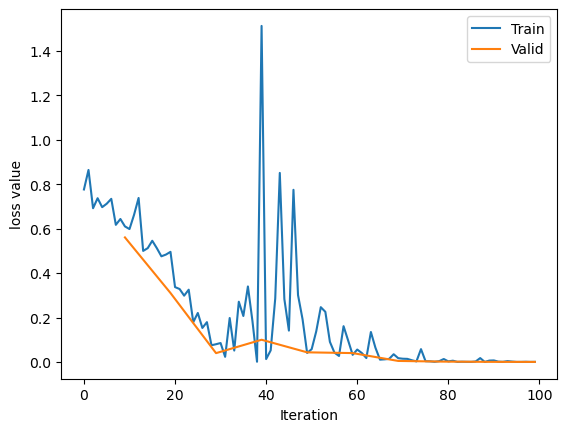

In [13]:
train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval - 1  # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

In [8]:
from model.lenet import LeNetSequential
net = LeNetSequential(classes=2)
summary(net,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                    [-1, 2]             170
Total params: 61,326
Trainable params: 61,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba